## Import and load the dataset

In [59]:
import pandas as pd
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name = "E Comm")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

## Bar chart to visualize how categorical features relate to churn

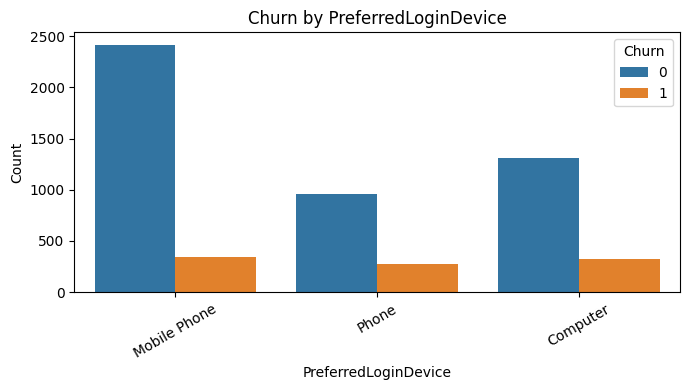

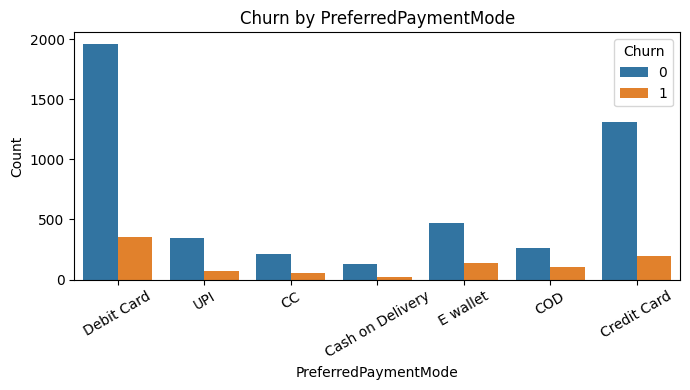

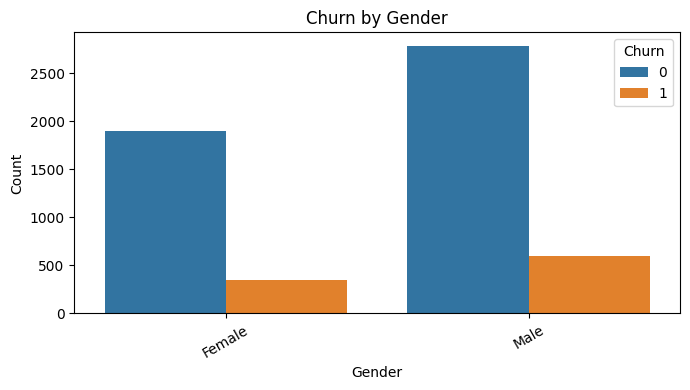

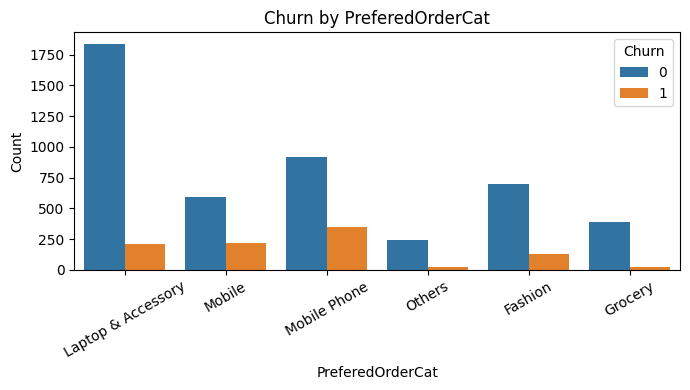

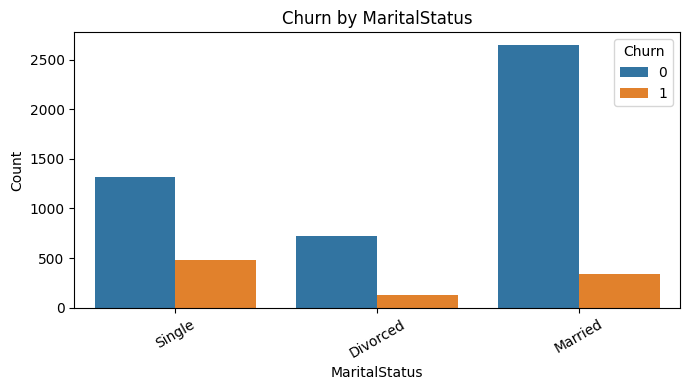

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'CustomerID']


for col in categorical_cols:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

## Preprocess the data and train the model with pipeline

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import joblib

# Fill missing values
df = df.fillna(0)

# Drop CustomerID if not useful
df = df.drop(columns=['CustomerID'])

# Define target and features
X = df.drop(columns=['Churn'])  # replace 'Churn' with your actual target column name
y = df['Churn']

# Separate categorical and numerical features
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Build preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [65]:
joblib.dump(pipeline, 'churn_pipeline.pkl')

['churn_pipeline.pkl']

## Import Gradio for web interface for model prediction

In [67]:
import gradio as gr

# Reload trained pipeline (to simulate final app)
pipeline = joblib.load('churn_pipeline.pkl')

# Define input feature names
feature_names = X.columns.tolist()

def predict_churn(*inputs):
    import pandas as pd
    data = pd.DataFrame([inputs], columns=feature_names)
    prediction = pipeline.predict(data)[0]
    prob = pipeline.predict_proba(data)[0][1]
    return f"Churn: {'Yes' if prediction else 'No'} (Probability: {prob:.2%})"

# Create Gradio UI components dynamically
gr_inputs = []
for col in feature_names:
    if col in categorical_cols:
        options = sorted(df[col].dropna().unique())
        gr_inputs.append(gr.Dropdown(choices=options, label=col))
    else:
        gr_inputs.append(gr.Number(label=col))

gr.Interface(
    fn=predict_churn,
    inputs=gr_inputs,
    outputs=gr.Text(label="Churn Prediction"),
    title="Customer Churn Predictor",
    description="Enter customer details to predict churn probability."
).launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## Graphical presentation of the model's performance

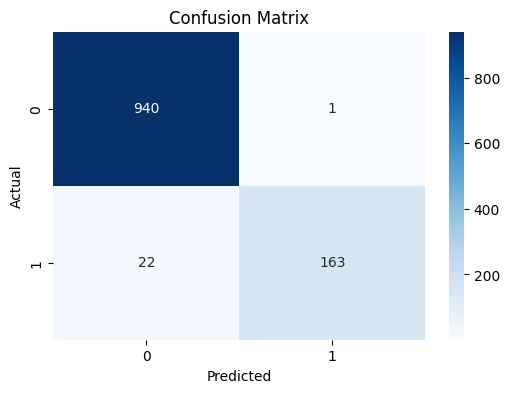

In [69]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

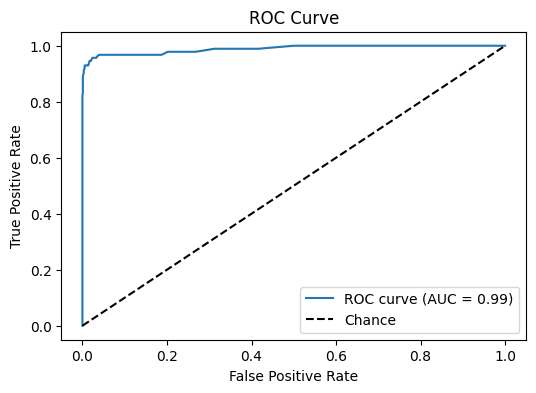

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       941
           1       0.99      0.88      0.93       185

    accuracy                           0.98      1126
   macro avg       0.99      0.94      0.96      1126
weighted avg       0.98      0.98      0.98      1126



In [72]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_names = numerical_cols + categorical_cols

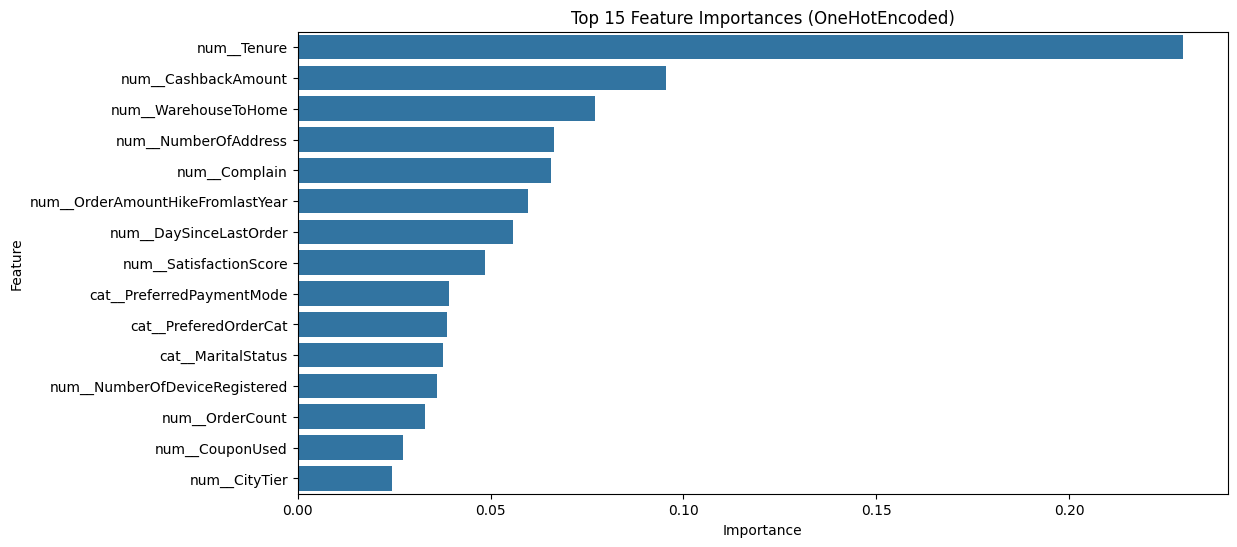

In [73]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = pipeline.named_steps['classifier'].feature_importances_

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (OneHotEncoded)")
plt.show()

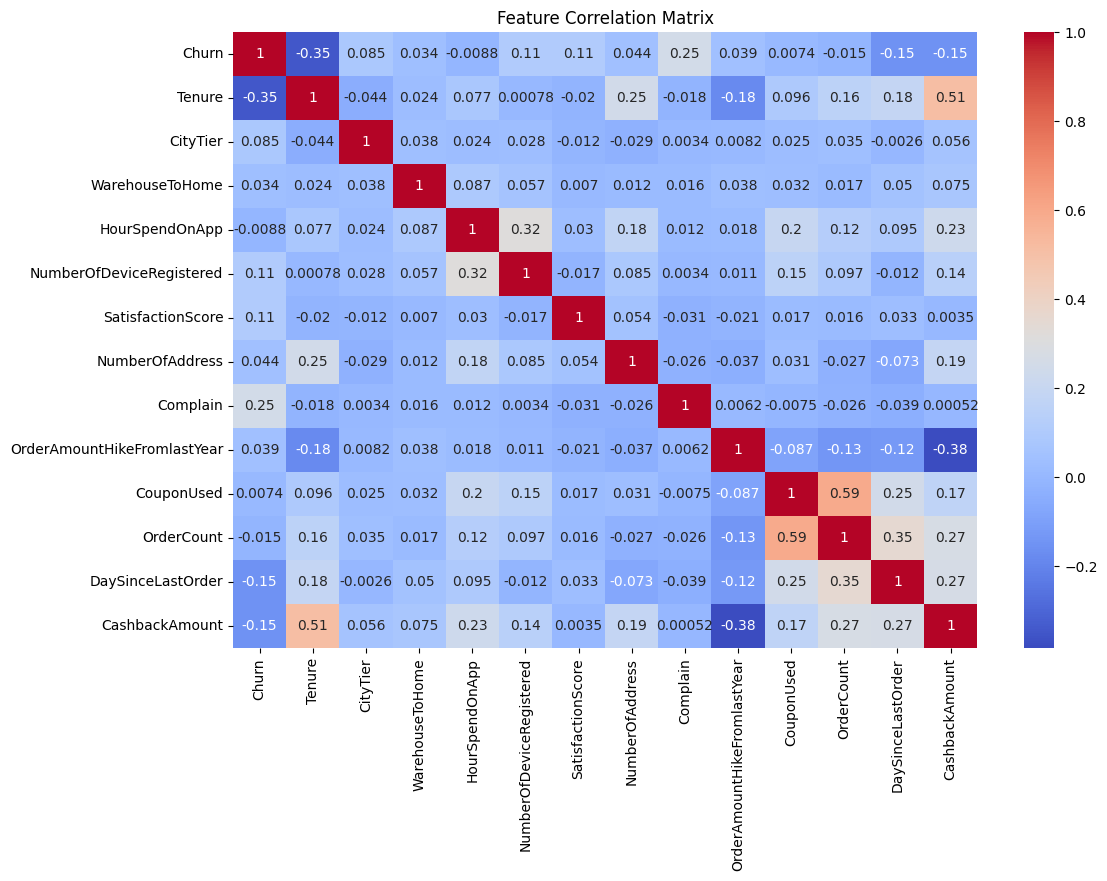

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only include numeric features (one-hot encoding will distort correlation for categories)
numeric_features = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()